In [1]:
import geopandas as gpd
import pandas as pd

In [2]:
gdf_residentials = gpd.read_file('../gangnamGu-building-residential.geojson', encoding='utf8', dtype={'USABILITY':str})

In [3]:
gdf_hexagons = gpd.read_file('../hexagon_res_9/hexagons.geojson')

## Calculate the number of residential buildings and total building area of residential buildings

In [4]:
# 01000 단독주택
# 01001 단독주택
single = ['01000','01001']

# 01002 다중주택
# 01003 다가구주택
# 02003 다세대주택
multi = ['01002','01003','02003']

# 02000 공동주택
# 02001 아파트
# 02002 연립주택
flat = ['02000','02001','02002']

# 10202 오피스텔
mxd = ['10202']

# 01004 공관
# 02007 기숙사 
etc = ['01004','02007']

In [5]:
gdf_residentials['USABILITY'].unique()

array(['01000', '02000'], dtype=object)

In [6]:
gdf_single = gdf_residentials.loc[gdf_residentials['USABILITY']=='01000']
gdf_multi = gdf_residentials.loc[gdf_residentials['USABILITY']=='02000']

In [7]:
gdf_residentials.shape

(11833, 15)

In [8]:
gdf_single.shape

(6484, 15)

In [9]:
gdf_multi.shape

(5349, 15)

In [10]:
def count_buildings(polygon, target_buildings):
    '''
    This function is for making a list of buildings that is in a hexagon area.
    -----
    input:
    polygon (Shapely.geometry.Polygon): a hexagon polygon 
    -----
    output:
    precise_matches_list (list): a list of residential buildings
    
    '''
    try:
        buildings_sindex = target_buildings.sindex
        possible_matches_index = list(buildings_sindex.intersection(polygon.bounds))
        possible_matches = target_buildings.iloc[possible_matches_index]
        # extract the list of buildings that is in a hexagon
        precise_matches_list = possible_matches[possible_matches.intersects(polygon)]['UFID'].tolist()
    except:
        # if there is no buildings that matched within a hexagon, return empty list
        precise_matches_list = []
    return precise_matches_list

In [11]:
gdf_hexagons['single_houses'] = gdf_hexagons['geometry'].apply(lambda x: count_buildings(x,gdf_single))

In [12]:
gdf_hexagons['multi_houses'] = gdf_hexagons['geometry'].apply(lambda x: count_buildings(x,gdf_multi))

In [13]:
gdf_residentials.columns

Index(['USABILITY', 'HEIGHT', 'PNU', 'GRND_FLR', 'UGRND_FLR', 'DONG_NM',
       'COL_ADM_SE', 'UFID', 'BLDG_PNU', 'BD_MGT_SN', 'ARCHAREA', 'TOTALAREA',
       'BC_RAT', 'VL_RAT', 'geometry'],
      dtype='object')

In [14]:
def sum_archarea(house_list):
    total = gdf_residentials.loc[gdf_residentials['UFID'].isin(house_list)]['ARCHAREA'].sum()
    return total

In [15]:
gdf_hexagons['single_archarea'] = gdf_hexagons['single_houses'].apply(lambda x: sum_archarea(x))

In [16]:
gdf_hexagons['multi_archarea'] = gdf_hexagons['multi_houses'].apply(lambda x: sum_archarea(x))

In [17]:
gdf_hexagons['single_count'] = gdf_hexagons['single_houses'].apply(lambda x: len(x))
gdf_hexagons['multi_count'] = gdf_hexagons['multi_houses'].apply(lambda x: len(x))

In [18]:
gdf_hexagons = gdf_hexagons.drop(['single_houses','multi_houses'], axis=1)

##  Count the number of public bike stations

In [19]:
gdf_bike = gpd.read_file('../publicBikeStation.geojson')

In [20]:
gdf_bike.head()

,stationid,gu,address,y,x,lcd_number,qr_number,type,geometry
0,1695,???,??? ??? 14,37.623417,127.066933,NaN,10.0,QR,POINT (127.06693 37.62342)
1,2301,???,????? ??? ???? 134,37.524071,127.021790,10.0,NaN,LCD,POINT (127.02179 37.52407)
2,2302,???,????? ??? ???? ?? 102,37.505581,127.024277,10.0,NaN,LCD,POINT (127.02428 37.50558)
3,2303,???,????? ??? ??? ?? 102,37.511517,127.021477,15.0,NaN,LCD,POINT (127.02148 37.51152)
4,2304,???,????? ??? ??? 626,37.512527,127.035835,10.0,NaN,LCD,POINT (127.03584 37.51253)


In [21]:
def count_stations(polygon, stations):
    try:
        station_sindex = stations.sindex
        possible_matches_index = list(station_sindex.intersection(polygon.bounds))
        possible_matches = stations.iloc[possible_matches_index]
        # extract the list of buildings that is in a hexagon
        precise_matches_list = possible_matches[possible_matches.intersects(polygon)]['stationid'].tolist()
    except:
        # if there is no station that matched within a hexagon, return empty list
        precise_matches_list = []
    return len(precise_matches_list)                        

In [22]:
gdf_hexagons['count_bike_station'] = gdf_hexagons['geometry'].apply(lambda x:count_stations(x,gdf_bike))

## Count the number of bus lines

In [23]:
gdf_bus_stop = gpd.read_file('../seoulBusStop.geojson', dtype={'ARS-ID':str})

In [24]:
gdf_bus_stop.head()

,표준ID,ARS-ID,정류장명,X좌표,Y좌표,geometry
0,100000001,1001,종로2가사거리,126.987750,37.569765,POINT (126.98775 37.56977)
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,POINT (126.99657 37.57918)
2,100000003,1003,명륜3가.성대입구,126.998340,37.582671,POINT (126.99834 37.58267)
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,POINT (126.98761 37.56858)
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,POINT (127.00174 37.58624)


In [25]:
df_bus_line = pd.read_csv('../seoulBusLine.csv')

In [26]:
df_bus_line.head()

,노선ID,노선명,순번,구간ID,정류소ID,ARS-ID,정류소명,X좌표,Y좌표
0,100100124,0017,1,0,102000271,3689,청암자이아파트,126.946517,37.534363
1,100100124,0017,2,102700549,102000204,3298,청암동강변삼성아파트,126.949304,37.533961
2,100100124,0017,3,102700550,102000227,3321,청심경로당,126.950449,37.533744
3,100100124,0017,4,102700551,102000210,3304,원효2동주민센터,126.950904,37.534278
4,100100124,0017,5,102700552,102000212,3306,산천동,126.953984,37.535420


In [27]:
def get_bus_stations(polygon, stations):
    try:
        station_sindex = stations.sindex
        possible_matches_index = list(station_sindex.intersection(polygon.bounds))
        possible_matches = stations.iloc[possible_matches_index]
        # extract the list of buildings that is in a hexagon
        precise_matches_list = possible_matches[possible_matches.intersects(polygon)]['표준ID'].tolist()
    except:
        # if there is no station that matched within a hexagon, return empty list
        precise_matches_list = []
    return precise_matches_list   

In [28]:
gdf_hexagons['bus_stops'] = gdf_hexagons['geometry'].apply(lambda x: get_bus_stations(x,gdf_bus_stop))

In [29]:
def count_bus_lines(bus_stops, lines):
    return len(lines[lines['정류소ID'].isin(bus_stops)]['노선ID'].unique().tolist())

In [30]:
gdf_hexagons['count_bus_line'] = gdf_hexagons['bus_stops'].apply(lambda x: count_bus_lines(x,df_bus_line))

In [31]:
gdf_hexagons.head()

,index,x,y,geometry,single_archarea,multi_archarea,single_count,multi_count,count_bike_station,bus_stops,count_bus_line
0,8930e1caa2bffff,127.090880,37.493859,"POLYGON ((127.09261 37.49364, 127.09186 37.495...",0.00,4203.610,0,9,0,[],0
1,8930e1c8487ffff,127.043237,37.488433,"POLYGON ((127.04497 37.48822, 127.04422 37.489...",512.36,3198.120,5,8,0,[],0
2,8930e1c8c33ffff,127.105979,37.486245,"POLYGON ((127.10771 37.48603, 127.10696 37.487...",0.00,1993.940,0,4,0,[],0
3,8930e1c818bffff,127.076602,37.479954,"POLYGON ((127.07833 37.47974, 127.07759 37.481...",28.76,28729.596,1,3,0,[],0
4,8930e1c881bffff,127.115170,37.470806,"POLYGON ((127.11690 37.47059, 127.11615 37.472...",0.00,0.000,0,0,0,[],0


In [32]:
gdf_hexagons = gdf_hexagons.drop('bus_stops', axis=1)

In [33]:
gdf_hexagons.head()

,index,x,y,geometry,single_archarea,multi_archarea,single_count,multi_count,count_bike_station,count_bus_line
0,8930e1caa2bffff,127.090880,37.493859,"POLYGON ((127.09261 37.49364, 127.09186 37.495...",0.00,4203.610,0,9,0,0
1,8930e1c8487ffff,127.043237,37.488433,"POLYGON ((127.04497 37.48822, 127.04422 37.489...",512.36,3198.120,5,8,0,0
2,8930e1c8c33ffff,127.105979,37.486245,"POLYGON ((127.10771 37.48603, 127.10696 37.487...",0.00,1993.940,0,4,0,0
3,8930e1c818bffff,127.076602,37.479954,"POLYGON ((127.07833 37.47974, 127.07759 37.481...",28.76,28729.596,1,3,0,0
4,8930e1c881bffff,127.115170,37.470806,"POLYGON ((127.11690 37.47059, 127.11615 37.472...",0.00,0.000,0,0,0,0


## Count subway lines

In [34]:
gdf_subway_station = gpd.read_file('../seoulSubwayStation.geojson')

In [35]:
gdf_subway_station.head()

,stationID,stationName,Line,y,x,geometry
0,2818,????,8,37.492522,127.118234,POINT (127.11823 37.49252)
1,340,????,3,37.492522,127.118234,POINT (127.11823 37.49252)
2,2535,??3?,5,37.571607,126.991806,POINT (126.99181 37.57161)
3,319,??3?,3,37.571607,126.991806,POINT (126.99181 37.57161)
4,153,??3?,1,37.571607,126.991806,POINT (126.99181 37.57161)


In [36]:
def count_subway_lines(polygon, stations):
    try:
        station_sindex = stations.sindex
        possible_matches_index = list(station_sindex.intersection(polygon.bounds))
        possible_matches = stations.iloc[possible_matches_index]
        # extract the list of buildings that is in a hexagon
        precise_matches_list = possible_matches[possible_matches.intersects(polygon)]['Line'].unique().tolist()
    except:
        # if there is no station that matched within a hexagon, return empty list
        precise_matches_list = []
    return len(precise_matches_list)  

In [37]:
gdf_hexagons['count_subway_line'] = gdf_hexagons['geometry'].apply(lambda x: count_subway_lines(x,gdf_subway_station))

## Calculate accessibility score

In [38]:
max_bus_line = gdf_hexagons['count_bus_line'].max()
max_bike_station = gdf_hexagons['count_bike_station'].max()
max_subway_station = gdf_hexagons['count_subway_line'].max()

In [39]:
print(max_bus_line, max_bike_station, max_subway_station)

23 2 2


In [40]:
gdf_hexagons.head()

,index,x,y,geometry,single_archarea,multi_archarea,single_count,multi_count,count_bike_station,count_bus_line,count_subway_line
0,8930e1caa2bffff,127.090880,37.493859,"POLYGON ((127.09261 37.49364, 127.09186 37.495...",0.00,4203.610,0,9,0,0,0
1,8930e1c8487ffff,127.043237,37.488433,"POLYGON ((127.04497 37.48822, 127.04422 37.489...",512.36,3198.120,5,8,0,0,0
2,8930e1c8c33ffff,127.105979,37.486245,"POLYGON ((127.10771 37.48603, 127.10696 37.487...",0.00,1993.940,0,4,0,0,0
3,8930e1c818bffff,127.076602,37.479954,"POLYGON ((127.07833 37.47974, 127.07759 37.481...",28.76,28729.596,1,3,0,0,0
4,8930e1c881bffff,127.115170,37.470806,"POLYGON ((127.11690 37.47059, 127.11615 37.472...",0.00,0.000,0,0,0,0,0


In [41]:
gdf_hexagons['score_bus'] = (gdf_hexagons['count_bus_line']/max_bus_line) * 5
gdf_hexagons['score_bike'] = (gdf_hexagons['count_bike_station']/max_bike_station) * 5
gdf_hexagons['score_subway'] = (gdf_hexagons['count_subway_line']/max_subway_station) * 5

In [42]:
gdf_hexagons['total_score'] = gdf_hexagons['score_bus'] + gdf_hexagons['score_bike'] + gdf_hexagons['score_subway']

In [43]:
gdf_hexagons['total_score'].max()

13.26086956521739

<AxesSubplot:>

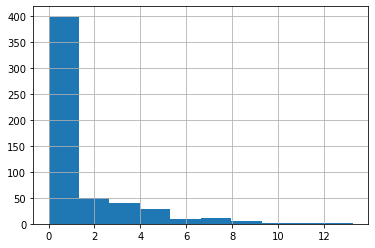

In [44]:
gdf_hexagons['total_score'].hist()

In [45]:
gdf_hexagons.to_file('../hexagon_res_9/hexagon_with_data.geojson', driver='GeoJSON', encoding='utf8')

In [46]:
gdf_hexagons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               547 non-null    object  
 1   x                   547 non-null    float64 
 2   y                   547 non-null    float64 
 3   geometry            547 non-null    geometry
 4   single_archarea     547 non-null    float64 
 5   multi_archarea      547 non-null    float64 
 6   single_count        547 non-null    int64   
 7   multi_count         547 non-null    int64   
 8   count_bike_station  547 non-null    int64   
 9   count_bus_line      547 non-null    int64   
 10  count_subway_line   547 non-null    int64   
 11  score_bus           547 non-null    float64 
 12  score_bike          547 non-null    float64 
 13  score_subway        547 non-null    float64 
 14  total_score         547 non-null    float64 
dtypes: float64(8), geometry(1), int6